# Hierachical Risk Parity Investment Strategy
## Use ETF of representative asset classes
#### Developed-Emerging Equity, Sector ,Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2012 to 2021 market data

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import os
import sys
import pandas as pd
import numpy as np
import datetime

from utils.yahoo_stock_data import yahoo_data

%matplotlib inline
from matplotlib import pyplot as plt

# import backtrader as bt
# import pyfolio as pf
import quantstats

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [11]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                    2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "RWX"   # SPDR® Dow Jones® International Real Estate ETF        2006-12-15
]

In [12]:
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': asset_class_ticker,
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

,IVV,IEFA,VWO,TLT,TIP,LQD,DBC,XAR,XLB,XLE,...,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.010435,0.009681,0.006732,-0.012985,-0.004885,-0.002596,0.003864,-0.009703,0.012302,0.009309,...,0.011224,0.011398,0.008137,0.005785,0.002734,0.007924,0.011605,0.010096,0.005698,0.003849
2013-02-04,-0.010919,-0.018424,-0.012930,0.012809,0.006489,0.003369,-0.003499,-0.007043,-0.009621,-0.009479,...,-0.013118,-0.011044,-0.009416,-0.012297,-0.006816,-0.011098,-0.009669,-0.009474,-0.001976,-0.013419
2013-02-05,0.009244,0.004405,0.002936,-0.008887,-0.002893,-0.002015,0.003862,0.008788,0.005113,0.008664,...,0.011588,-0.004330,0.011950,0.010642,0.002745,0.010989,0.009432,0.014505,-0.002640,0.006072
2013-02-06,0.001318,0.001335,-0.002477,0.008191,0.001161,0.002607,-0.001399,0.003974,0.001017,0.000641,...,-0.000337,0.019684,0.001342,0.002186,0.003011,-0.000231,0.002951,-0.002072,0.002383,0.000483
2013-02-07,-0.001184,-0.009141,-0.008126,-0.002223,-0.000911,0.000335,-0.003853,-0.000304,-0.005336,-0.002563,...,0.000000,-0.005387,0.005361,-0.002181,0.001364,-0.003701,-0.007192,-0.010797,-0.003433,-0.006274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,-0.002314,-0.002677,-0.010410,-0.012094,-0.006347,-0.006789,0.002256,-0.012794,-0.010440,-0.001684,...,0.005873,-0.026402,-0.007613,-0.004847,-0.008196,-0.005226,-0.007803,-0.019589,-0.013284,-0.001494
2022-01-27,-0.005213,-0.007205,-0.008870,0.018363,0.004072,0.002279,0.004953,-0.027823,0.003396,0.010890,...,-0.006888,-0.015599,0.006729,-0.024240,0.008864,0.002587,-0.009771,-0.045541,-0.013822,-0.002095
2022-01-28,0.024448,0.003985,0.001665,0.000349,0.003499,0.001098,0.000896,0.006153,0.005801,-0.004248,...,0.043731,0.008532,0.011765,0.021802,0.012063,0.020411,0.021661,0.035902,0.028031,0.004498


In [16]:
# correlation matrix
corr = yield_df.corr()
# distance matrix
d_corr = np.sqrt(0.5*(1-corr))
d_corr = d_corr.fillna(0)


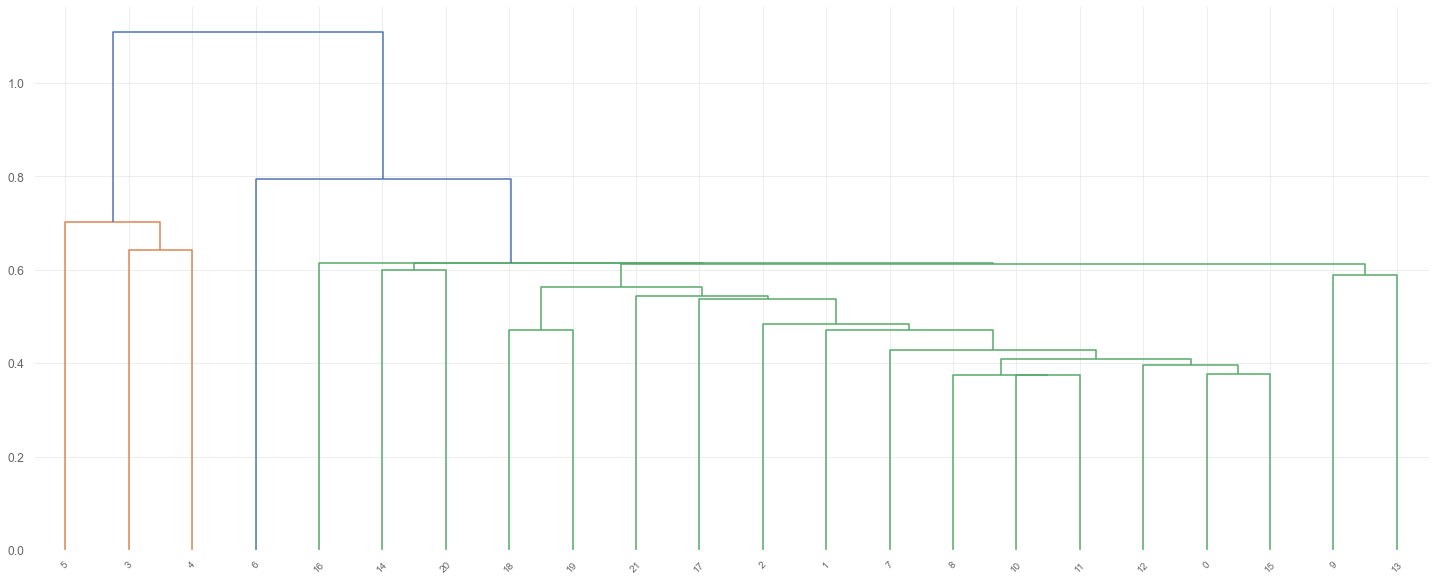

In [18]:
link_corr = linkage(d_corr, 'single')
Z = pd.DataFrame(link_corr)

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [19]:
def get_quasi_diag(link):

    # sort clustered items by distance

    link = link.astype(int)

    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]])

    # the total num of items is the third item of the last list
    num_items = link[-1,3]

    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:

        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # make space

        df0 = sort_ix[sort_ix >= num_items] # find clusters

        # df0 contains even index and cluster index
        i = df0.index
        j = df0.values - num_items

        sort_ix[i] = link[j,0] # item 1

        df0  = pd.Series(link[j, 1], index=i+1)

        sort_ix = sort_ix.append(df0) # item 2
        sort_ix = sort_ix.sort_index()

        sort_ix.index = range(sort_ix.shape[0])

    return sort_ix.tolist()

def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inverse-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)

    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]

        # parse in pairs
        for i in range(0, len(c_items), 2):

            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2

            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)

            alpha = 1 - c_var0/(c_var0+c_var1)

            w[c_items0] *= alpha
            w[c_items1] *=1-alpha

    return w

In [20]:
sort_index = get_quasi_diag(link_corr)
print(sort_index)

[5, 3, 4, 6, 16, 14, 20, 18, 19, 21, 17, 2, 1, 7, 8, 10, 11, 12, 0, 15, 9, 13]

In [22]:
asset_cov = yield_df.cov()
weights = get_rec_bipart(cov=asset_cov, sort_ix=sort_index)

In [23]:
new_index = [yield_df.columns[i] for i in weights.index]
weights.index = new_index
weights

<BarContainer object of 22 artists>

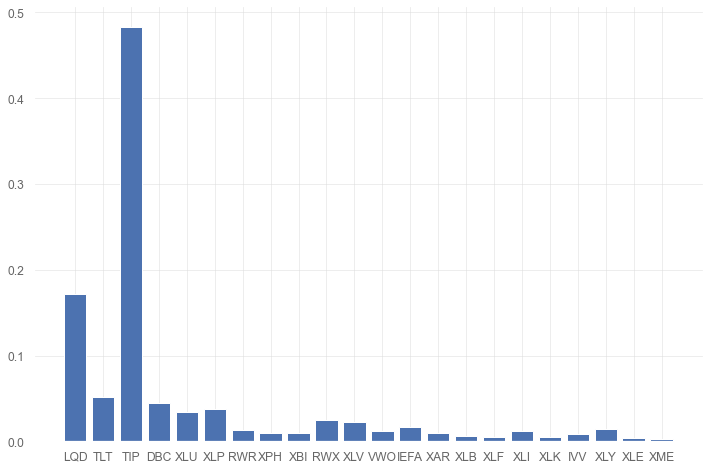

In [24]:
plt.figure(figsize = (12, 8))
plt.bar(list(weights.index), weights)

([<matplotlib.patches.Wedge at 0x1d00d4f2cd0>,
 [Text(0.9426981870367961, 0.5668510634704128, 'LQD'),
  Text(0.3522951491259807, 1.0420595606309186, 'TLT'),
  Text(-1.0740379936614632, 0.23757606817955926, 'TIP'),
  Text(-0.1426052832037102, -1.0907170729398115, 'DBC'),
  Text(0.12954627795000928, -1.092345074538856, 'XLU'),
  Text(0.37103440000658344, -1.0355353562345202, 'XLP'),
  Text(0.5302344704067974, -0.9637693740685181, 'RWR'),
  Text(0.5966715309209419, -0.9241120517493859, 'XPH'),
  Text(0.6509970414122502, -0.8866808061938056, 'XBI'),
  Text(0.7428456316798184, -0.8112831611060418, 'RWX'),
  Text(0.8548327314606595, -0.692286791166427, 'XLV'),
  Text(0.9231658800902424, -0.5981343978047146, 'VWO'),
  Text(0.9727095129003683, -0.513649884175134, 'IEFA'),
  Text(1.0120961541215805, -0.430884410036272, 'XAR'),
  Text(1.032766202957786, -0.3786739627016322, 'XLB'),
  Text(1.0464545250506068, -0.33901759099065826, 'XLF'),
  Text(1.0637898045226173, -0.2799129360957291, 'XLI'),
  

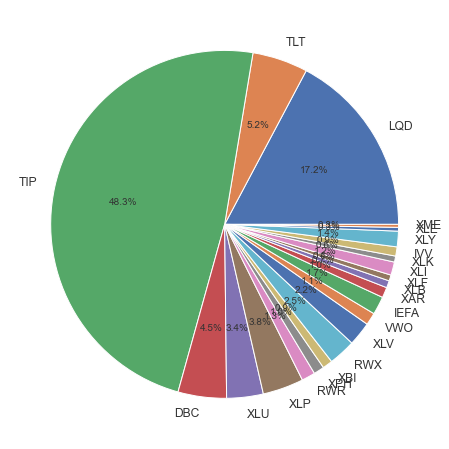

In [29]:
plt.figure(figsize = (12, 8))
plt.pie(weights, labels=list(weights.index), autopct='%.1f%%')